In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\mall.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
class AdvancedGMM:
    def __init__(self, n_components, max_iter=200, tol=1e-5, reg_covar=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        
    def fit(self, X):
        n_samples, n_features = X.shape
        
        self.weights_ = np.ones(self.n_components) / self.n_components
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances_ = [np.eye(n_features) for _ in range(self.n_components)]
        self.lower_bound = -np.inf
        
        for iteration in range(self.max_iter):
            resp = self._expectation(X)
            
            self._maximization(X, resp)
            
            new_lower_bound = self._compute_lower_bound(X, resp)
            
            if np.abs(new_lower_bound - self.lower_bound) < self.tol:
                break
                
            self.lower_bound = new_lower_bound
            
        return self
    
    def _expectation(self, X):
        resp = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            try:
                resp[:, k] = self.weights_[k] * multivariate_normal.pdf(
                    X, 
                    mean=self.means_[k], 
                    cov=self.covariances_[k] + self.reg_covar*np.eye(X.shape[1])
                )
            except:
                resp[:, k] = 1e-8 
        resp_sum = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / resp_sum
        return resp
    
    def _maximization(self, X, resp):
        resp_sum = resp.sum(axis=0)
        
        self.weights_ = resp_sum / X.shape[0]
        
        self.means_ = np.dot(resp.T, X) / resp_sum[:, np.newaxis]
        
        for k in range(self.n_components):
            diff = X - self.means_[k]
            cov = np.dot(resp[:, k] * diff.T, diff) / resp_sum[k]
            self.covariances_[k] = cov + self.reg_covar * np.eye(X.shape[1])
    
    def _compute_lower_bound(self, X, resp):
        log_prob = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            try:
                log_prob[:, k] = multivariate_normal.logpdf(
                    X, 
                    mean=self.means_[k], 
                    cov=self.covariances_[k] + self.reg_covar*np.eye(X.shape[1])
                )
            except:
                log_prob[:, k] = -np.inf
        return np.sum(resp * (log_prob + np.log(self.weights_))) - np.sum(resp * np.log(resp + 1e-8))
    
    def predict(self, X):
        return np.argmax(self._expectation(X), axis=1)


In [11]:
n_components = 5
gmm = AdvancedGMM(n_components=n_components)
gmm.fit(X_scaled)

labels = gmm.predict(X_scaled)

In [12]:
silhouette = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette:.3f}")

Silhouette Score: 0.183


Text(0.5, 1.0, 'GMM Clustering (n_components=5)\nSilhouette Score: 0.183')

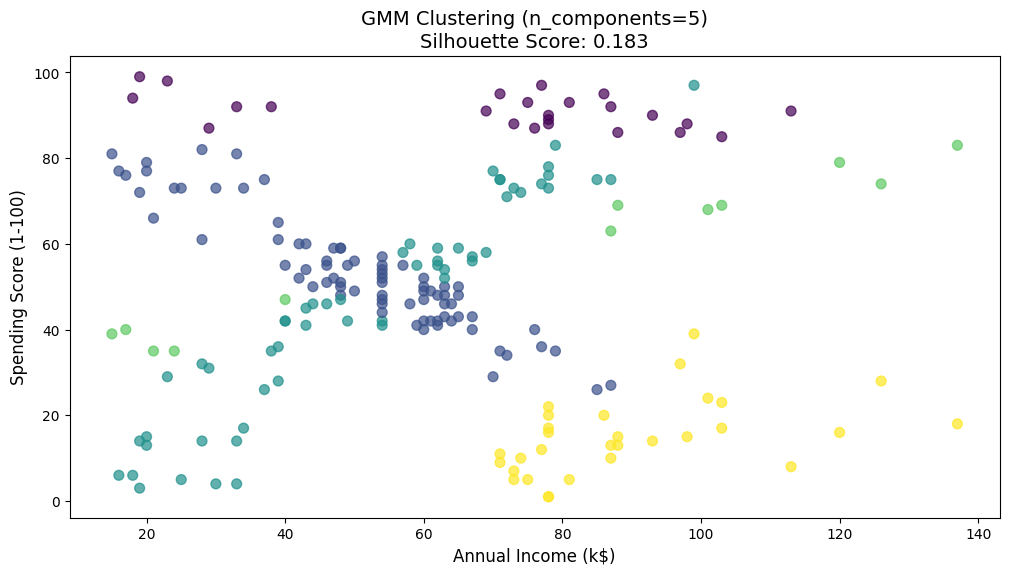

In [13]:
plt.figure(figsize=(12, 6))
plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.title(f'GMM Clustering (n_components={n_components})\nSilhouette Score: {silhouette:.3f}', fontsize=14)

C:\Users\Robyi\AppData\Local\Temp\ipykernel_15700\3091755085.py:20: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = plt.matplotlib.patches.Ellipse(


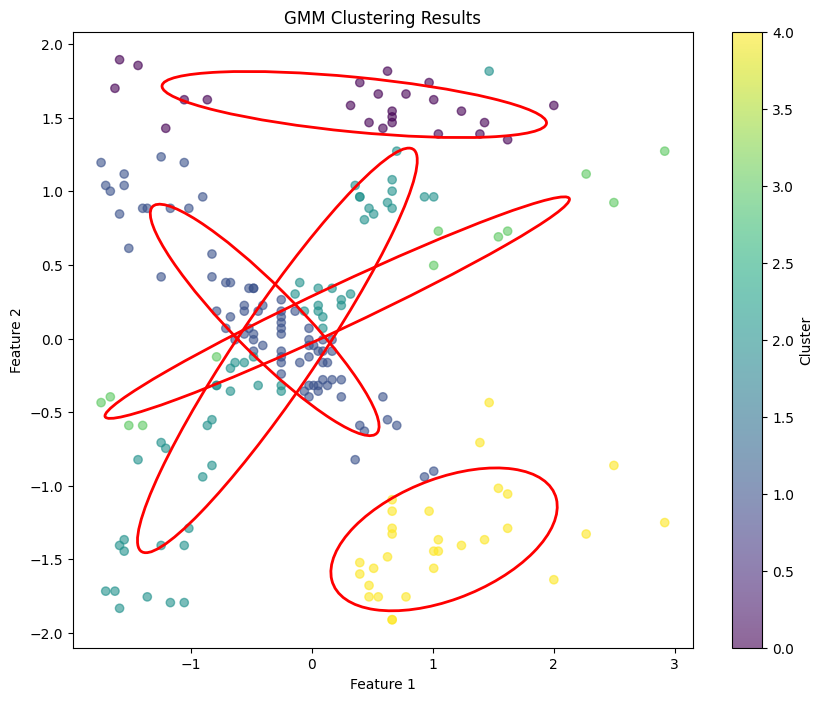

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', alpha=0.6)

for k in range(gmm.n_components):

    covar = gmm.covariances_[k]
    mean = gmm.means_[k]
    
    v, w = np.linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi
    
    ell = plt.matplotlib.patches.Ellipse(
        mean, v[0], v[1], 180 + angle,
        edgecolor='red',
        lw=2,
        fill=False
    )
    plt.gca().add_patch(ell)

plt.colorbar(scatter, label='Cluster')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('GMM Clustering Results')

plt.show()

In [19]:
print("\nModel Parameters:")
for k in range(n_components):
    print(f"Component {k+1}:")
    print(f"  Weight: {gmm.weights_[k]:.3f}")
    print(f"  Mean (scaled): {gmm.means_[k]}")
    print(f"  Mean (original): {scaler.inverse_transform(gmm.means_[k].reshape(1, -1))[0]}")
    print(f"  Covariance:\n{gmm.covariances_[k]}\n")


Model Parameters:
Component 1:
  Weight: 0.105
  Mean (scaled): [0.35282225 1.59010753]
  Mean (original): [69.80358196 91.15939215]
  Covariance:
[[ 1.26132775 -0.0988666 ]
 [-0.0988666   0.02519624]]

Component 2:
  Weight: 0.346
  Mean (scaled): [-0.38741383  0.12667239]
  Mean (original): [50.41015397 53.46293922]
  Covariance:
[[ 0.44681568 -0.34149882]
 [-0.34149882  0.30906315]]

Component 3:
  Weight: 0.308
  Mean (scaled): [-0.28260345 -0.08029195]
  Mean (original): [53.15607877 48.13176917]
  Covariance:
[[0.66796765 0.74650625]
 [0.74650625 0.94457476]]

Component 4:
  Weight: 0.091
  Mean (scaled): [0.21193169 0.21027364]
  Mean (original): [66.11239349 55.61641379]
  Covariance:
[[1.84094193 0.7057931 ]
 [0.7057931  0.28323195]]

Component 5:
  Weight: 0.150
  Mean (scaled): [ 1.09456968 -1.36410501]
  Mean (original): [89.23660587 15.06218015]
  Covariance:
[[0.43716884 0.10443063]
 [0.10443063 0.117757  ]]

